In [17]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio
print(torch.__version__)
print(torchaudio.__version__)
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from torchaudio.datasets import SPEECHCOMMANDS
import os
import torch.nn as nn
import torch.nn.functional
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial
from tqdm import tqdm
from sklearn.metrics import accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)

2.2.0+cu121
2.2.0+cu121
cuda


In [2]:

class SubsetSC(SPEECHCOMMANDS):
    """
    A class representing a subset of the Speech Commands dataset.

    Args:
        subset (str, optional): The subset to load. Can be one of "validation", "testing", or "training". Defaults to None.
        url (str, optional): The URL to download the dataset from. Defaults to "speech_commands_v0.01".

    Attributes:
        _walker (list): A list of file paths representing the subset.

    """
    def __init__(self, subset: str = None, url="speech_commands_v0.01"): 
        super().__init__("./", url=url, download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

train_set = SubsetSC("training")
test_set = SubsetSC("testing")
valid_set = SubsetSC("validation")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [3]:
print("length of train_set: ", len(train_set))
print("length of test_set: ", len(test_set))
print("length of valid_set: ", len(valid_set))

length of train_set:  51088
length of test_set:  6835
length of valid_set:  6798


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


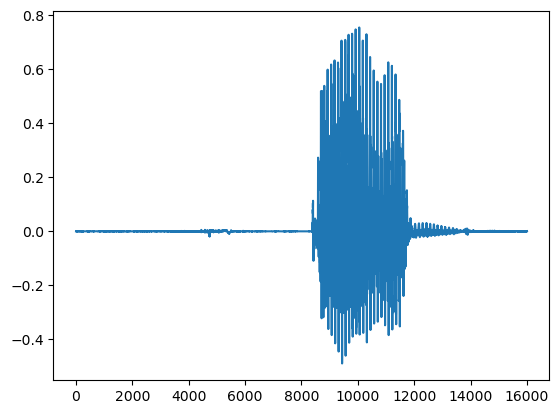

In [4]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())

Let’s find the list of labels available in the dataset.

In [5]:
# words = sorted(list(set(datapoint[2] for datapoint in test_set))) # Get the words spoken in the dataset
words = ['bed','bird','cat','dog','down','eight','five','four','go','happy','house','left','marvin','nine','no','off','on','one','right','seven','sheila','six','stop','three','tree','two','up','wow','yes','zero']

We are encoding each word using its index in the list of labels.

In [6]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(words.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return words[index]


# Test 
word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(28) --> yes


In [7]:
# extraction des features mfcc

n_fft = 1024 
n_mels = 40
n_mfcc = 40
hop_length = int(0.04 * 16000)  # 40 ms en échantillons
win_length = int(0.03 * 16000)  # 20 ms en échantillons
sample_rate = 16000

# MFCC transform object 
mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "win_length": win_length,
        "mel_scale": "htk",
    },
).to(device)
    
# Fonction pour l'augmentation des données
def data_augmentation(waveform, parameters):
    # Time shift perturbation
    if parameters["time_shift"][0]:
        shift_ms = random.uniform(parameters["time_shift"][1][0], parameters["time_shift"][1][1])
        shift_samples = int(sample_rate * shift_ms / 1000)
        waveform = torch.roll(waveform, shifts=shift_samples, dims=-1)

    # Add white noise with magnitude [-90, -46] dB
    if parameters["noise"][0]:
        noise_dB = random.uniform(parameters["noise"][1][0], parameters["noise"][1][1])
        noise_power = torch.pow(10.0, noise_dB / 10)
        noise = torch.randn(waveform.size(), device=device) * noise_power
        waveform += noise

    # Apply SpecAugment
    # 2 continuous time masks of size [0, 25] time steps
    if parameters["time_mask"][0]:
        time_masking = T.TimeMasking(time_mask_param=random.randint(parameters["time_mask"][1][0], parameters["time_mask"][1][1])).to(device)
        waveform = time_masking(waveform)
        waveform = time_masking(waveform)  # Apply twice for 2 continuous time masks

    if parameters["freq_mask"][0]:
        # 2 continuous frequency masks of size [0, 15] frequency bands
        frequency_masking = T.FrequencyMasking(freq_mask_param=random.randint(parameters["freq_mask"][1][0], parameters["freq_mask"][1][1])).to(device)
        waveform = frequency_masking(waveform)
        waveform = frequency_masking(waveform)  # Apply twice for 2 continuous frequency masks
        
    return waveform
        


In [8]:
def extract_mfcc(batch, parameters, augment=False, augment_type="duplicate", type_pad="zero", reshape=False):

    tensors, targets = [], []

    for waveform, _, label, *_ in batch:
        
        if waveform.size(1) < 16000:
            # Pad the waveform if it is shorter than 1 second
            waveform = torch.nn.functional.pad(waveform, (0, sample_rate - waveform.size(1)), value=0)
        elif waveform.size(1) > 16000:
            # Trim the waveform if it is longer than 1 second
            waveform = waveform[:, :16000]

        # Apply data augmentation to the waveform
        waveform = waveform.to(device)
        if augment:
            if augment_type == "duplicate":
                waveformAug = data_augmentation(waveform, parameters)
            elif augment_type == "random" :
                # dans 30 % des cas on applique l'augmentation
                waveformAug = data_augmentation(waveform, parameters) if random.random() < 0.3 else waveform
            else :
                waveformAug = waveform
            # Apply MFCC transform to the augmented waveform
            waveformAug = mfcc_transform(waveformAug)

            if reshape:
                waveformAug = waveformAug.reshape(1, -1)
            tensors.append(waveformAug)
            targets += [label_to_index(label)]
        
        # Apply MFCC transform to the waveform
        waveform = mfcc_transform(waveform)
        if reshape:
            waveform = waveform.reshape(1, -1)

        tensors.append(waveform)
        targets += [label_to_index(label)]
        
    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.stack(targets)

    if reshape: 
        tensors = tensors.squeeze(1)
    return tensors, targets


In [9]:
# implémentation d'un modèle pas très complexe
import copy
class SimpleNeuralNet(nn.Module):
    """
    A simple neural network model for classification tasks.
    Args:
        input_size (int): The number of input features.
        hidden_size (int): The number of units in the hidden layer.
        num_classes (int): The number of output classes.
    """
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        """
        Forward pass of the neural network.
        Args:
            x (torch.Tensor): The input tensor.    
        Returns:
            torch.Tensor: The output tensor.
        """
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
# Fonction d'entraînement
def train(model,train_loader, criterion, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) # Charger les données sur le GPU
        output = model(data) # Prédiction du modèle
        loss = criterion(output, target) # Calcul de la perte
        optimizer.zero_grad() # Remettre à zéro les gradients
        loss.backward() # Calcul des gradients
        optimizer.step() # Mise à jour des poids
                     
# Fonction d'évaluation
def validation(model, validation_loader, criterion, best_accuracy, best_model, epoch):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # Number of correct predictions

    accuracy = correct / len(validation_loader.dataset) # Accuracy
    print("epoch: ", epoch+1, "accuracy: ", accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        return copy.deepcopy(model), best_accuracy
    return best_model, best_accuracy

# Fonction de test
def test(model, test_loader): 
    model = model.to(device)
    model.eval() # Mettre le modèle en mode évaluation
    predictions = torch.tensor([], device=device)
    targets = torch.tensor([], device=device)
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            predictions = torch.cat((predictions, pred), dim=0)
            targets = torch.cat((targets, target), dim=0)
    return predictions.cpu().numpy(), targets.cpu().numpy()

In [10]:

def global_function(
        model = None,
        optimizer = None,
        criterion = None,
        batch = 256,
        augment_type = "duplicate",
        parameters = None,
        augment = False,
        num_epochs = 10,
        reshape = False,
    ):
    
    batch_size = batch//2 if augment and augment_type == "duplicate" else batch # Batch size for training
    num_workers, pin_memory = (1, True) if device == "cuda" else (0, False)

    extract_mfcc_train = partial(extract_mfcc, parameters=parameters, augment=augment, augment_type=augment_type, reshape=reshape)

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=extract_mfcc_train, 
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    extract_mfcc_valid = partial(extract_mfcc, parameters=parameters, reshape=reshape)

    valid_loader = DataLoader(
        valid_set,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        collate_fn=extract_mfcc_valid,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    # Training function
    best_model = None
    best_accuracy = 0

    for epoch in tqdm(range(num_epochs)):
        train(model, train_loader, criterion, optimizer)
        best_model, best_accuracy = validation(model, valid_loader, criterion, best_accuracy, best_model, epoch)
    
    return best_model


In [60]:
input_size = (sample_rate//hop_length + 1) * n_mfcc
model = SimpleNeuralNet(input_size=input_size, hidden_size=256, num_classes=30).to(device)
# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Paramètres pour la data augmentation
parameters = {
    "time_shift": [True, [0, 100]],  # Time shift perturbation
    "noise": [True, [-90, -46]],  # Add white noise
    "time_mask": [True, [0, 25]],  # Time masking
    "freq_mask": [True, [0, 15]],  # Frequency masking
}

# Entraînement du modèle
best_model = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=False,
    num_epochs=10,
    reshape=True,
)

 10%|█         | 1/10 [01:13<11:02, 73.66s/it]

epoch:  1 accuracy:  0.6150338334804354


 20%|██        | 2/10 [02:22<09:28, 71.03s/it]

epoch:  2 accuracy:  0.695204471903501


 30%|███       | 3/10 [03:29<08:04, 69.24s/it]

epoch:  3 accuracy:  0.7177110914974992


 40%|████      | 4/10 [04:38<06:53, 68.86s/it]

epoch:  4 accuracy:  0.7328626066490144


 50%|█████     | 5/10 [05:47<05:45, 69.02s/it]

epoch:  5 accuracy:  0.7512503677552221


 60%|██████    | 6/10 [06:59<04:39, 69.88s/it]

epoch:  6 accuracy:  0.754780817887614


 70%|███████   | 7/10 [08:09<03:29, 69.97s/it]

epoch:  7 accuracy:  0.7558105325095617


 80%|████████  | 8/10 [09:20<02:20, 70.35s/it]

epoch:  8 accuracy:  0.7522800823771697


 90%|█████████ | 9/10 [10:28<01:09, 69.79s/it]

epoch:  9 accuracy:  0.7475728155339806


100%|██████████| 10/10 [11:39<00:00, 69.95s/it]

epoch:  10 accuracy:  0.757428655486908


100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


Test Accuracy:  0.7350402340892466
Test Classification Report:
              precision    recall  f1-score   support

         bed       0.66      0.72      0.68       176
        bird       0.74      0.80      0.77       158
         cat       0.71      0.77      0.74       166
         dog       0.59      0.69      0.64       180
        down       0.72      0.66      0.68       253
       eight       0.78      0.81      0.79       257
        five       0.67      0.63      0.65       271
        four       0.85      0.75      0.80       253
          go       0.60      0.48      0.53       251
       happy       0.88      0.88      0.88       180
       house       0.86      0.84      0.85       150
        left       0.64      0.76      0.69       267
      marvin       0.75      0.75      0.75       162
        nine       0.57      0.76      0.65       259
          no       0.52      0.66      0.58       252
         off       0.89      0.72      0.79       262
          on      

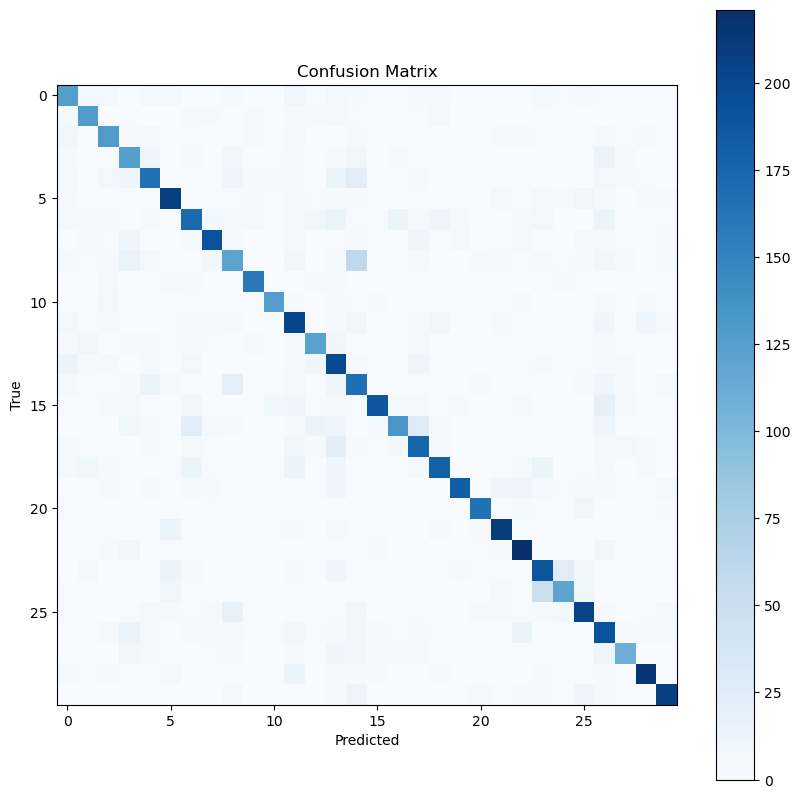

In [61]:
# TEST DU MODELE
# Extraction des features MFCC
extract_mfcc_test = partial(extract_mfcc, parameters=parameters, augment=False, reshape=True)

num_workers, pin_memory = (1, True) if device == "cuda" else (0, False)

test_loader = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc_test,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

predictions, targets = test(best_model, test_loader)
print("Test Accuracy: ", accuracy_score(targets, predictions))


# Afficher les performances
print("Test Classification Report:")
print(classification_report(targets, predictions, target_names=words))

# Matrice de confusion
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Time shift 

In [62]:
parameters = {
    "time_shift": [True, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
}
model = SimpleNeuralNet(input_size=input_size, hidden_size=500, num_classes=30).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Entraînement du modèle
best_model_shift = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    num_epochs=10,
    augment_type="random",
    reshape=True,
)


 10%|█         | 1/10 [01:52<16:49, 112.18s/it]

epoch:  1 accuracy:  0.6557811120917917


 20%|██        | 2/10 [03:45<15:03, 112.88s/it]

epoch:  2 accuracy:  0.7122683142100618


 30%|███       | 3/10 [05:36<13:04, 112.06s/it]

epoch:  3 accuracy:  0.7250661959399823


 40%|████      | 4/10 [07:28<11:12, 112.08s/it]

epoch:  4 accuracy:  0.754339511621065


 50%|█████     | 5/10 [09:21<09:21, 112.29s/it]

epoch:  5 accuracy:  0.754780817887614


 60%|██████    | 6/10 [11:12<07:27, 111.88s/it]

epoch:  6 accuracy:  0.7594880847308032


 70%|███████   | 7/10 [13:05<05:36, 112.15s/it]

epoch:  7 accuracy:  0.7612533097969991


 80%|████████  | 8/10 [14:57<03:44, 112.05s/it]

epoch:  8 accuracy:  0.7772874374816122


 90%|█████████ | 9/10 [16:46<01:51, 111.12s/it]

epoch:  9 accuracy:  0.7755222124154163


100%|██████████| 10/10 [18:36<00:00, 111.66s/it]

epoch:  10 accuracy:  0.7750809061488673


In [63]:
predictions_shift, targets_shift = test(best_model_shift, test_loader)
print("Test Accuracy: ", accuracy_score(targets_shift, predictions_shift))


100%|██████████| 27/27 [00:08<00:00,  3.33it/s]

Test Accuracy:  0.7612289685442575


### TIME_MASKING

In [66]:
parameters = {
    "time_shift": [False, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [True, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
}
model = SimpleNeuralNet(input_size=input_size, hidden_size=500, num_classes=30).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Entraînement du modèle
best_model_TM = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    num_epochs=10,
    augment_type="random",
    reshape=True,
)


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [03:20<30:04, 200.46s/it]

epoch:  1 accuracy:  0.6478375992939099


 20%|██        | 2/10 [05:19<20:20, 152.58s/it]

epoch:  2 accuracy:  0.7215357458075905


 30%|███       | 3/10 [07:19<16:02, 137.52s/it]

epoch:  3 accuracy:  0.7481612238893792


 40%|████      | 4/10 [09:19<13:04, 130.74s/it]

epoch:  4 accuracy:  0.744777875845837


 50%|█████     | 5/10 [11:16<10:29, 125.89s/it]

epoch:  5 accuracy:  0.7480141218005296


 60%|██████    | 6/10 [13:13<08:11, 122.86s/it]

epoch:  6 accuracy:  0.764342453662842


 70%|███████   | 7/10 [15:13<06:05, 121.72s/it]

epoch:  7 accuracy:  0.7628714327743454


 80%|████████  | 8/10 [17:12<04:02, 121.03s/it]

epoch:  8 accuracy:  0.7606649014416005


 90%|█████████ | 9/10 [19:10<02:00, 120.17s/it]

epoch:  9 accuracy:  0.7693439246837305


100%|██████████| 10/10 [21:09<00:00, 126.91s/it]

epoch:  10 accuracy:  0.7616946160635482


In [67]:
predictions_TM, targets_TM = test(best_model_TM, test_loader)
print("Test Accuracy: ", accuracy_score(targets_TM, predictions_TM))

100%|██████████| 27/27 [00:38<00:00,  1.43s/it]

Test Accuracy:  0.7489392831016826


### FREQUENCY_MASKING

In [68]:
parameters = {
    "time_shift": [False, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [True, [0, 15]],  # Frequency masking
}
model = SimpleNeuralNet(input_size=input_size, hidden_size=500, num_classes=30).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Entraînement du modèle
best_model_FM = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    num_epochs=10,
    augment_type="random",
    reshape=True,
)


 10%|█         | 1/10 [01:59<17:55, 119.55s/it]

epoch:  1 accuracy:  0.6425419240953222


 20%|██        | 2/10 [04:00<16:04, 120.56s/it]

epoch:  2 accuracy:  0.7077081494557222


 30%|███       | 3/10 [06:01<14:04, 120.62s/it]

epoch:  3 accuracy:  0.7377169755810532


 40%|████      | 4/10 [08:03<12:07, 121.20s/it]

epoch:  4 accuracy:  0.7559576345984113


 50%|█████     | 5/10 [10:06<10:08, 121.73s/it]

epoch:  5 accuracy:  0.7594880847308032


 60%|██████    | 6/10 [12:07<08:06, 121.51s/it]

epoch:  6 accuracy:  0.7530155928214181


 70%|███████   | 7/10 [14:05<06:01, 120.44s/it]

epoch:  7 accuracy:  0.7616946160635482


 80%|████████  | 8/10 [16:06<04:01, 120.51s/it]

epoch:  8 accuracy:  0.7549279199764637


 90%|█████████ | 9/10 [18:06<02:00, 120.48s/it]

epoch:  9 accuracy:  0.7684613121506325


100%|██████████| 10/10 [20:06<00:00, 120.63s/it]

epoch:  10 accuracy:  0.7624301265077964


In [69]:
predictions_FM, targets_FM = test(best_model_FM, test_loader)
print("Test Accuracy: ", accuracy_score(targets_FM, predictions_FM))

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]

Test Accuracy:  0.7442574981711778


### FREQUENCY_MASKING, TIME_MASKING, TIME_SHIFT

In [71]:
parameters = {
    "time_shift": [True, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [True, [0, 25]],  # Time masking
    "freq_mask": [True, [0, 15]],  # Frequency masking
}
model = SimpleNeuralNet(input_size=input_size, hidden_size=500, num_classes=30).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Entraînement du modèle
best_model_TFM = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    num_epochs=10,
    augment_type="random",
    reshape=True,
)


 10%|█         | 1/10 [02:10<19:37, 130.84s/it]

epoch:  1 accuracy:  0.6145925272138865


 20%|██        | 2/10 [04:58<20:19, 152.46s/it]

epoch:  2 accuracy:  0.7035892909679318


 30%|███       | 3/10 [07:46<18:38, 159.75s/it]

epoch:  3 accuracy:  0.7411003236245954


 40%|████      | 4/10 [10:01<14:59, 149.89s/it]

epoch:  4 accuracy:  0.7469844071785819


 50%|█████     | 5/10 [12:15<12:01, 144.21s/it]

epoch:  5 accuracy:  0.754339511621065


 60%|██████    | 6/10 [14:33<09:28, 142.04s/it]

epoch:  6 accuracy:  0.7522800823771697


 70%|███████   | 7/10 [16:49<06:59, 139.96s/it]

epoch:  7 accuracy:  0.7691968225948809


 80%|████████  | 8/10 [18:59<04:33, 136.93s/it]

epoch:  8 accuracy:  0.7689026184171815


 90%|█████████ | 9/10 [21:45<02:25, 145.95s/it]

epoch:  9 accuracy:  0.7621359223300971


100%|██████████| 10/10 [24:00<00:00, 144.01s/it]

epoch:  10 accuracy:  0.7603706972639012


In [72]:
predictions_TFM, targets_TFM = test(best_model_TFM, test_loader)
print("Test Accuracy: ", accuracy_score(targets_TFM, predictions_TFM))

100%|██████████| 27/27 [00:08<00:00,  3.19it/s]

Test Accuracy:  0.7487929773226042


# Implementation CNN

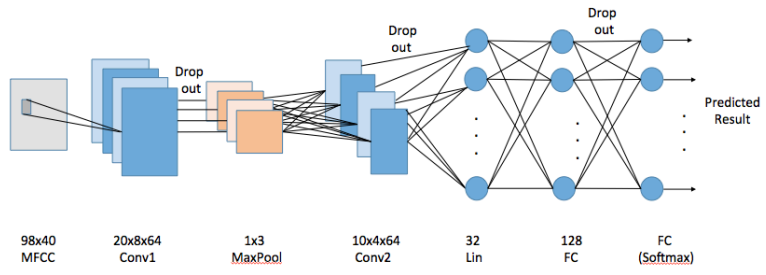

In [11]:
class MFCC_CNN(nn.Module):
    def __init__(self, num_classes=30):
        super(MFCC_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=7, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=7, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = None
        self.fc2 = nn.Linear(in_features=500, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(torch.relu(self.bn1(self.conv1(x))))
        x = self.maxpool(torch.relu(self.bn2(self.conv2(x))))
        if self.fc1 is None:
            num_features_after_conv = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(in_features=num_features_after_conv, out_features=500).to(x.device)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [67]:
class MFCC_CNN(nn.Module):
    def __init__(self, num_classes=30):
        super(MFCC_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=7, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=7, padding=1)
        self.fc1 = None
        self.fc2 = nn.Linear(in_features=500, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxpool(x)
        x = torch.relu(self.conv2(x))
        x = self.maxpool(x)
        if self.fc1 is None:
            num_features_after_conv = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(in_features=num_features_after_conv, out_features=500).to(x.device)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# Paramètres pour la data augmentation
parameters = {
    "time_shift": [True, [0, 100]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
}

model = MFCC_CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du modèle
best_model_cnn = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=False,
    augment_type="random",
    num_epochs=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [05:50<52:31, 350.14s/it]

epoch:  1 accuracy:  0.8399529273315681


 20%|██        | 2/10 [07:14<25:50, 193.82s/it]

epoch:  2 accuracy:  0.8445130920859076


 30%|███       | 3/10 [08:36<16:38, 142.60s/it]

epoch:  3 accuracy:  0.8724624889673434


 40%|████      | 4/10 [10:07<12:14, 122.36s/it]

epoch:  4 accuracy:  0.8932038834951457


 50%|█████     | 5/10 [11:35<09:10, 110.05s/it]

epoch:  5 accuracy:  0.8857016769638129


 60%|██████    | 6/10 [12:59<06:43, 101.00s/it]

epoch:  6 accuracy:  0.8674610179464548


 70%|███████   | 7/10 [14:13<04:36, 92.20s/it] 

epoch:  7 accuracy:  0.8876140041188585


 80%|████████  | 8/10 [15:27<02:52, 86.44s/it]

epoch:  8 accuracy:  0.8737864077669902


 90%|█████████ | 9/10 [16:42<01:22, 82.88s/it]

epoch:  9 accuracy:  0.8859958811415122


100%|██████████| 10/10 [18:01<00:00, 108.17s/it]

epoch:  10 accuracy:  0.8718740806119447


In [21]:
extract_mfcc_cnn = partial(extract_mfcc, parameters=parameters, augment=False)
num_workers, pin_memory = (1, True) if device == "cuda" else (0, False)
test_loader = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc_cnn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

predictions_cnn, targets_cnn = test(best_model_cnn, test_loader)
print("Test Accuracy: ", accuracy_score(targets_cnn, predictions_cnn))

100%|██████████| 27/27 [00:09<00:00,  2.90it/s]

Test Accuracy:  0.8857351865398684


### Time shift

In [22]:
# Paramètres pour la data augmentation
parameters = {
    "time_shift": [True, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
}

model = MFCC_CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du modèle
best_model_cnn_TS = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    augment_type="random",
    num_epochs=10,
)

 10%|█         | 1/10 [02:03<18:28, 123.18s/it]

epoch:  1 accuracy:  0.8245072080023537


 20%|██        | 2/10 [04:10<16:44, 125.50s/it]

epoch:  2 accuracy:  0.853486319505737


 30%|███       | 3/10 [06:14<14:35, 125.06s/it]

epoch:  3 accuracy:  0.8857016769638129


 40%|████      | 4/10 [08:20<12:30, 125.14s/it]

epoch:  4 accuracy:  0.8864371874080612


 50%|█████     | 5/10 [10:20<10:16, 123.29s/it]

epoch:  5 accuracy:  0.8620182406590173


 60%|██████    | 6/10 [12:22<08:12, 123.04s/it]

epoch:  6 accuracy:  0.883053839364519


 70%|███████   | 7/10 [14:23<06:06, 122.16s/it]

epoch:  7 accuracy:  0.8818770226537217


 80%|████████  | 8/10 [16:24<04:03, 121.84s/it]

epoch:  8 accuracy:  0.8868784936746101


 90%|█████████ | 9/10 [18:29<02:02, 122.97s/it]

epoch:  9 accuracy:  0.8758458370108856


100%|██████████| 10/10 [20:38<00:00, 123.89s/it]

epoch:  10 accuracy:  0.8914386584289496


In [23]:
predictions_cnn_TS, targets_cnn = test(best_model_cnn_TS, test_loader)
print("Test Accuracy: ", accuracy_score(targets_cnn, predictions_cnn_TS))

100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

Test Accuracy:  0.885003657644477


In [ ]:
# Paramètres pour la data augmentation
parameters = {
    "time_shift": [False, [-10, 10]],  # Time shift perturbation
    "noise": [False, [-90, -46]],  # Add white noise
    "time_mask": [False, [0, 25]],  # Time masking
    "freq_mask": [False, [0, 15]],  # Frequency masking
}

model = MFCC_CNN(num_classes=30).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Entraînement du modèle
best_model_cnn_TS = global_function(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch=256,
    parameters=parameters,
    augment=True,
    augment_type="random",
    num_epochs=10,
)

#### Il faut continuer les tests ...